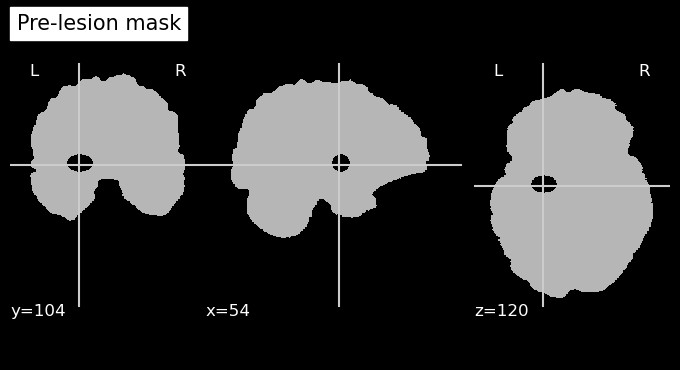

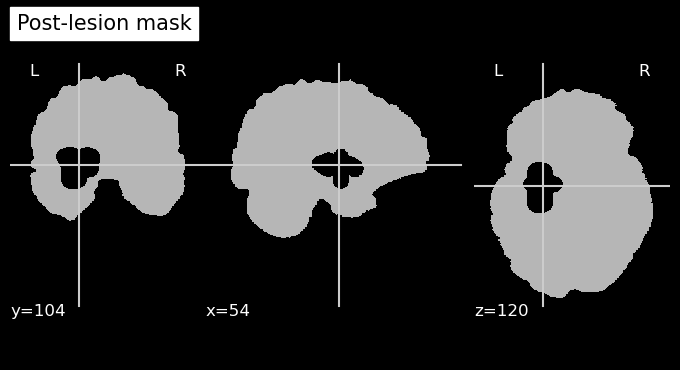

In [6]:
from nilearn.plotting import plot_anat


pre_lesion = '/deneb_disk/auto_resection/lesion_masks/lesion10.mask.nii.gz'
post_lesion = '/deneb_disk/auto_resection/lesion_masks/lesion11.mask.nii.gz'

cross_hair = (54, 104, 120)
plot_anat(pre_lesion, title='Pre-lesion mask', cut_coords=cross_hair)
plot_anat(post_lesion, title='Post-lesion mask', cut_coords=cross_hair)


In [15]:

from warper import Warper

nonlin_reg = Warper()
pre2post_lesion = '/deneb_disk/auto_resection/lesion_masks/pre2post_lesion.nii.gz'
ddf = '/deneb_disk/auto_resection/lesion_masks/pre2post_lesion_ddf.nii.gz'
jac_file = '/deneb_disk/auto_resection/lesion_masks/pre2post_lesion_jac.nii.gz'
nonlin_reg.nonlinear_reg(
    target_file=post_lesion,
    moving_file=pre_lesion,
    output_file=pre2post_lesion,
    ddf_file=ddf,
    reg_penalty=3,
    nn_input_size=64,
    lr=1e-3,
    max_epochs=1000,
    loss="mse",
    jacobian_determinant_file=jac_file)


/opt/conda/lib/python3.11/site-packages/monai/networks/blocks/warp.py:72: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


optimizing
finished  1000  epochs3m 0.03  



computing deformation field
applying warp
saving warped output: /deneb_disk/auto_resection/lesion_masks/pre2post_lesion.nii.gz
saving ddf: /deneb_disk/auto_resection/lesion_masks/pre2post_lesion_ddf.nii.gz


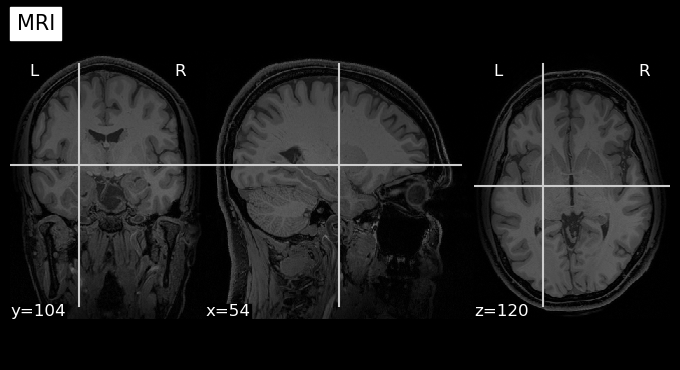

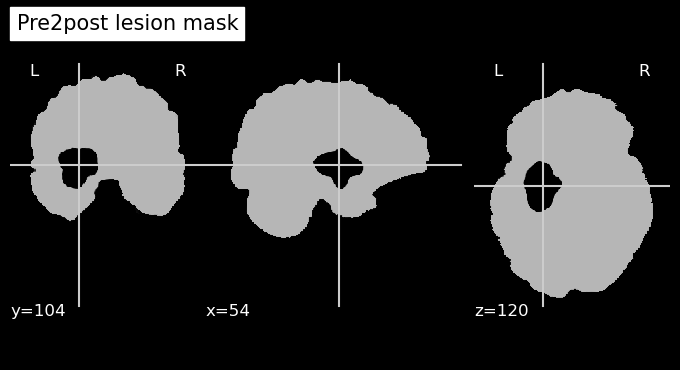

In [32]:
from warp_utils import apply_warp
from monai.transforms import LoadImage, EnsureChannelFirst
import nibabel as nib

mri = '/deneb_disk/auto_resection/lesion_masks/USCBrain.nii.gz'
plot_anat(mri, title='MRI', cut_coords=cross_hair)

plot_anat(pre2post_lesion, title='Pre2post lesion mask', cut_coords=cross_hair)

moving = LoadImage(image_only=True)(pre_lesion)
moving = EnsureChannelFirst()(moving)[None]
target = LoadImage(image_only=True)(post_lesion)
target = EnsureChannelFirst()(target)[None]
disp = LoadImage(image_only=True)(ddf)
disp = EnsureChannelFirst()(disp)[None]
mri = LoadImage(image_only=True)(mri)
mri = EnsureChannelFirst()(mri)[None]

output_file='/deneb_disk/auto_resection/lesion_masks/pre2post_lesion_check.nii.gz'
moved = apply_warp(disp_field=disp, moving_image=moving, target_image=target)
nib.save(nib.Nifti1Image(moved[0, 0].detach().cpu().numpy(), target.affine), output_file)


target = LoadImage(image_only=True)(post_lesion)
target = EnsureChannelFirst()(target)[None]
disp = LoadImage(image_only=True)(ddf)
disp = EnsureChannelFirst()(disp)[None]
mri = LoadImage(image_only=True)(mri)
mri = EnsureChannelFirst()(mri)[None]
output_file='/deneb_disk/auto_resection/lesion_masks/pre2post_mri.nii.gz'
moved = apply_warp(disp_field=disp, moving_image=mri, target_image=target)
nib.save(nib.Nifti1Image(moved[0, 0].detach().cpu().numpy(), target.affine), output_file)


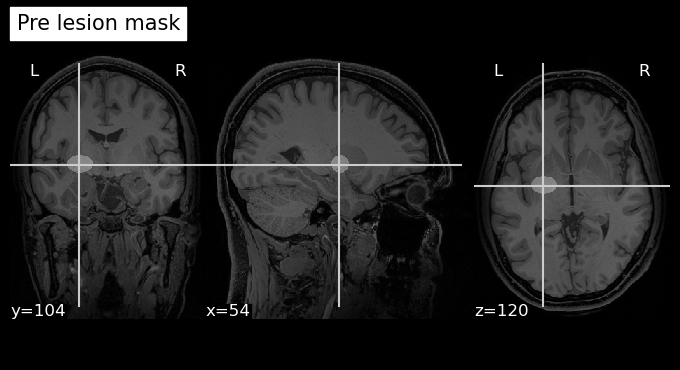

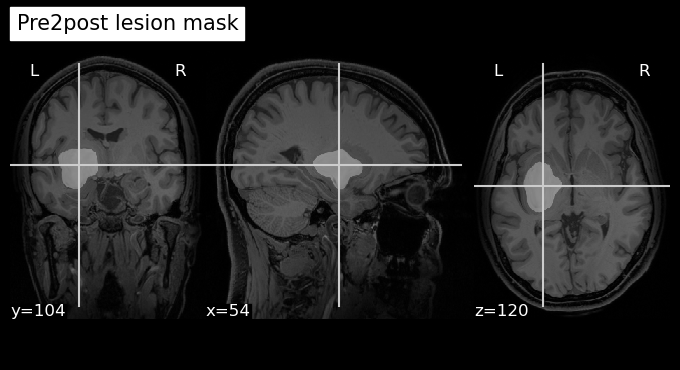

In [40]:

lesion_file = '/deneb_disk/auto_resection/lesion_masks/pre_lesion.mask.nii.gz'
lesion_mri = '/deneb_disk/auto_resection/lesion_masks/USCBrain.pre_lesion.nii.gz'

target = LoadImage(image_only=True)(post_lesion)
target = EnsureChannelFirst()(target)[None]
disp = LoadImage(image_only=True)(ddf)
disp = EnsureChannelFirst()(disp)[None]
lesion = LoadImage(image_only=True)(lesion_file)
lesion = EnsureChannelFirst()(lesion)[None]
lesion = mri + lesion
nib.save(nib.Nifti1Image(lesion[0, 0].detach().cpu().numpy(), target.affine), lesion_mri)

output_file='/deneb_disk/auto_resection/lesion_masks/pre2post_lesion.nii.gz'
moved = apply_warp(disp_field=disp, moving_image=lesion, target_image=target)
nib.save(nib.Nifti1Image(moved[0, 0].detach().cpu().numpy(), target.affine), output_file)


plot_anat(lesion_mri, title='Pre lesion mask', cut_coords=cross_hair)
plot_anat(output_file, title='Pre2post lesion mask', cut_coords=cross_hair)
